# Parallelize code with `dask.delayed`

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Delayed
- Create Date: 2021-May
- Lineage/Reference: This tutorial is referenced to [dask-tutorial](https://github.com/dask/dask-tutorial)
----

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`.

* Basics
* Parallelize with the dask.delayed decorator
* Dask delayed annotation
* Parallelize a for loop
---

## Set up

Create a client:

In [1]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)
print(client.dashboard_link)

/Users/hugo/opt/anaconda3/envs/nci/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52368 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:52369' processes=4 threads=4, memory=8.00 GiB>
http://127.0.0.1:52368/status


Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

## Basics

Let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally and in the following section we'll parallelize these functions.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time
# This takes three seconds to run because we call each function sequentially, one after the other.

x = inc(1)
y = inc(2)
z = add(x, y)
z

CPU times: user 212 ms, sys: 56.5 ms, total: 269 ms
Wall time: 3.01 s


5

### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called *in parallel*.

We'll wrap the `inc` and `add` functions in the `dask.delayed` decorator. When we call the delayed version by passing the arguments, the original function isn't actually called yet.
Instead, a *task graph* is built up, representing the *delayed* function call.

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)
z.dask

CPU times: user 1.08 ms, sys: 228 µs, total: 1.31 ms
Wall time: 1.33 ms


HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x11f29e8e0>
 0. inc-4d8d42ee-b812-4a1a-b19a-c00e8afa33ac
 1. inc-5b916506-16cf-4d69-a63b-cda2c1986f48
 2. add-d0175525-0f34-41f2-a762-47f64a33399d

This ran immediately, since nothing has really happened yet (i.e, variable `z` does not return any value but rather returns a delayed object).

To get the result, call `compute()`.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 410 ms, sys: 176 ms, total: 585 ms
Wall time: 2.63 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result.  We can compute the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [7]:
z.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x11f29e8e0>
 0. inc-4d8d42ee-b812-4a1a-b19a-c00e8afa33ac
 1. inc-5b916506-16cf-4d69-a63b-cda2c1986f48
 2. add-d0175525-0f34-41f2-a762-47f64a33399d

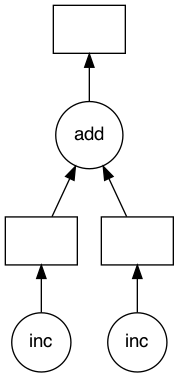

In [8]:
# Look at the task graph for `z`
z.visualize()

We can visualize the chain of calculations that the object `total` corresponds to as follows: the circles are functions, rectangles are data/results.

### Dask Delayed annotation

Dask allows you to construct a prescription for the calculation you want to carry out. This is an alternative way to utilize dask.delayed functions. You can achieve this while programming with perfectly ordinary Python functions and for-loops.

In [9]:

@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

Instead of using the `dask.delayed` function (i.e., `delayed(inc)`) as in the previous session, here we use the delayed annotation to show that we want these functions to operate lazily which will save the set of inputs and execute only on demand. 

In [10]:
# this looks like ordinary code
x = inc(15)
y = inc(30)
total = add(x, y)
total.dask
# x, y and total are all delayed objects. 
# They contain a prescription of how to execute

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x11f29eb80>
 0. inc-7a2de963-7ab8-4fd1-8ab0-a27b720d9211
 1. inc-a1e864e6-116a-4e62-9acd-057bfcb1e0ef
 2. add-84529921-842c-4c37-a1ac-b5bcccd07e67

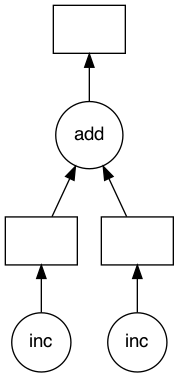

In [11]:
total.visualize()

## Challenge 

Think about the following

Why were we not able to go below 2 seconds? Write your answer in the Markdown cell below. 


 why are we not able to go below 2 seconds ...

The answer to this is related to **Amhdahl's law**, which states that the maximum speedup you can acheive by running code in parallel is fundamentally limited by the non-parallel parts. This has an exact [mathematical expression](https://en.wikipedia.org/wiki/Amdahl%27s_law) for those who are interested.



For example if we have a computation that takes 20 hours on a single thread, but a single hour of the computation cannot be parallelised, the minimum execution time we can acheive is ~ 1hr hour, no matter how many resources we throw at our parallel part. 

In [12]:
data = [i for i in range(10)]

@delayed
def non_parallel(data):
    sleep(10)
    return data

@delayed    
def parallel_add(x):
    
    sleep(1)
    return(x+1)

@delayed
def agg(data):
    return(sum(data))


results = []

for x in data:
    y = parallel_add(x)
    results.append(y)
    
total = non_parallel(agg(results))




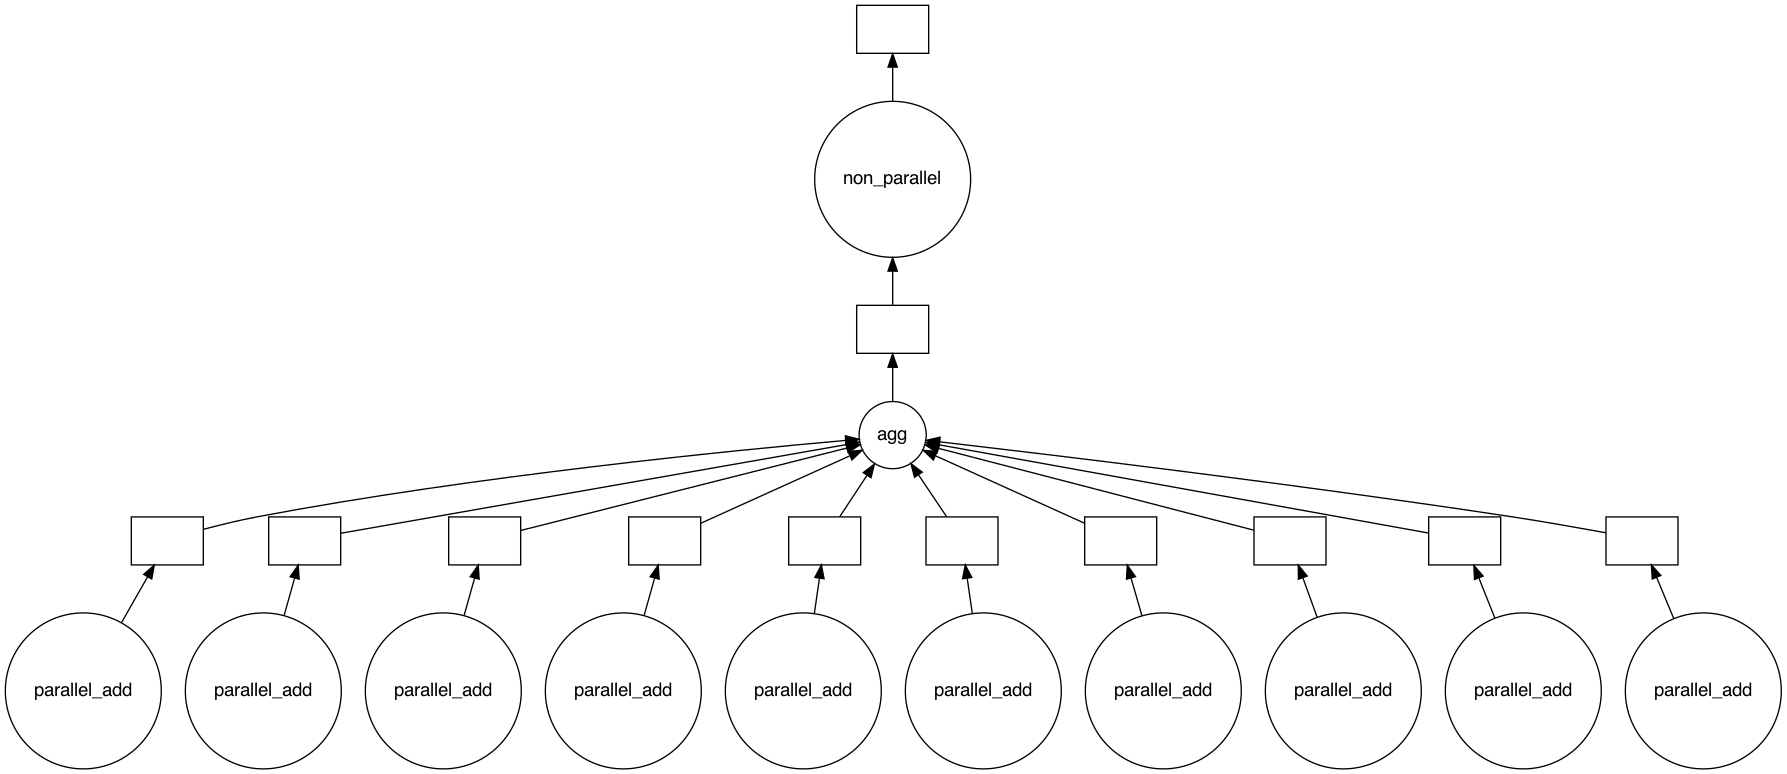

In [13]:
total.dask
total.visualize()

What do you notice about this task graph?

In [14]:
%%time 
total.compute()

CPU times: user 998 ms, sys: 251 ms, total: 1.25 s
Wall time: 13.1 s


55

This example shows us that fundamentally our calculation is  limited by by our non-parallel part with the rest of the compute only taking ~ 3 sec on my 4 thread machine. 

Thinking about the parallel part:

Given 4 workers and 10 tasks total ~3 secs makes sense as they complete 4 tasks over 1 sec at full saturation, another 4 over 1 sec at full saturation and then 2 over 1 sec at half saturation. 

Thinking about parallel excecution can be tricky, but thinking about these kinds of things will help you make the best use of your compute resources!

## Okay cool but how useful is this?

We have just shown how we can use `Dask` to parallelize almost any code! `Dask` is also great at increasing the amout of parallelism in your whole program, not just one part using `delayed`. This helps us skirt around Amdahl's law as much as possible. 

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` to parallelize the computation below:

$result = sin(x) + 1 $

over a list of x.

We are going to add a delay (`sleep(1)`) to simulate additional work done and make parallel speedups more obvious.

In [39]:
import numpy as np
from dask import array as da

n_vals = 10
x_val = np.arange(n_vals).tolist()

def sin_x_1(x):
    sleep(1)
    return np.sin(x) + 1

@delayed
def sin_x_1_delayed(x):
    sleep(1)
    return np.sin(x) + 1


In [42]:
%%time
# Sequential code

results = []
for x in x_val:
    res = sin_x_1(x)
    results.append(res)

total = sum(results)

CPU times: user 4.07 ms, sys: 3.09 ms, total: 7.16 ms
Wall time: 10 s


In [43]:
total

11.955209482107382

In [47]:
%%time
# dask code

results = []
for x in x_val:
    res = sin_x_1_delayed(x)
    results.append(res)

total = delayed(sum(results))

CPU times: user 1.29 ms, sys: 30 µs, total: 1.32 ms
Wall time: 1.34 ms


In [45]:
total.dask

HighLevelGraph with 20 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x120e060a0>
 0. sin_x_1_delayed-8dbde90c-504c-4cb4-8bc0-961e415f8020
 1. sin_x_1_delayed-e44717b9-863d-48a9-8fc8-c74b29926833
 2. sin_x_1_delayed-946b461d-cf2a-4cf3-a997-dfb1aff72f6b
 3. sin_x_1_delayed-fb9119ff-954a-4fe5-89e9-f1b56dc715f0
 4. sin_x_1_delayed-3d69b937-290d-406d-9f4c-e8be935765c6
 5. sin_x_1_delayed-6618a783-704f-4127-9897-b5007dfb7c3e
 6. sin_x_1_delayed-1597a372-5a8c-4fdb-85be-7415de9483d5
 7. sin_x_1_delayed-db7962ff-56e7-492b-af43-267a55225572
 8. sin_x_1_delayed-e6c5cd5b-34f9-4f14-977d-bdb4f190a48f
 9. sin_x_1_delayed-8398d316-bf23-496c-8512-caa4e5a1b40c
 10. _inner-9f608891f118d2964f450ddb738c4020
 11. add-dc4023d01a6e53d3ec939c3c92c5b4da
 12. add-8da63f61170c9d9906c9888caa838f5f
 13. add-540f5aee45096d7407c2ec436701d8c3
 14. add-ca5674a05dc2c56a54566f01090f6107
 15. add-300f51aa8976271aab0450159474c5ef
 16. add-ab871e02a1d2e91ce4438a707280ef63
 17. add-2e79f3e5a91f5b4043970225b87b9190
 18. add-932d30fe147447c338a9cdc9aaa7da70
 19. add-373b26c93043a6d24153da75cce9e8b4

In [46]:
%%time
total.compute()

CPU times: user 9.7 ms, sys: 6.58 ms, total: 16.3 ms
Wall time: 3.03 s


11.955209482107382

**Note the difference in execution times!**

Also note that the benefits of parallelism will become more obvious the more work done by each thread. That's why we have been using all these sleep calls.

# Challenge

**Create a for loop with a dependency**.

Performance can be reduced (sometimes unavoidably) if a data dependency is introduced into the chain of execution. Can you create such a loop using the above `sin_x_1` and another function?


In [58]:
# create a for loop with a dependency and examine its task graph and execution time. 

#hint use this function to hold your result for 1 sec
@delayed
def data_dependency(data):
    sleep(1)
    return data


<details><summary><b>Solution</b></summary>
   <pre>
    <br>@delayed
def data_dependency(data):
    sleep(1)
    return data

running_sum = 0
for x in x_val:
    res = sin_x_1_delayed(x)
    res = data_dependency(res)
    running_sum += res
running_sum.dask
   </pre>
</details>




## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision to delay or not to delay requires careful thought when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [20]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [21]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

Delayed('add-468f3043472976013e6f8ddcfd88fd94')
CPU times: user 353 ms, sys: 93.2 ms, total: 446 ms
Wall time: 5.02 s


In [62]:
%%time
# lazy version

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 1.14 ms, sys: 725 µs, total: 1.86 ms
Wall time: 2.94 ms


In [63]:
%time total.compute()

CPU times: user 5.85 ms, sys: 3.66 ms, total: 9.5 ms
Wall time: 3.02 s


90

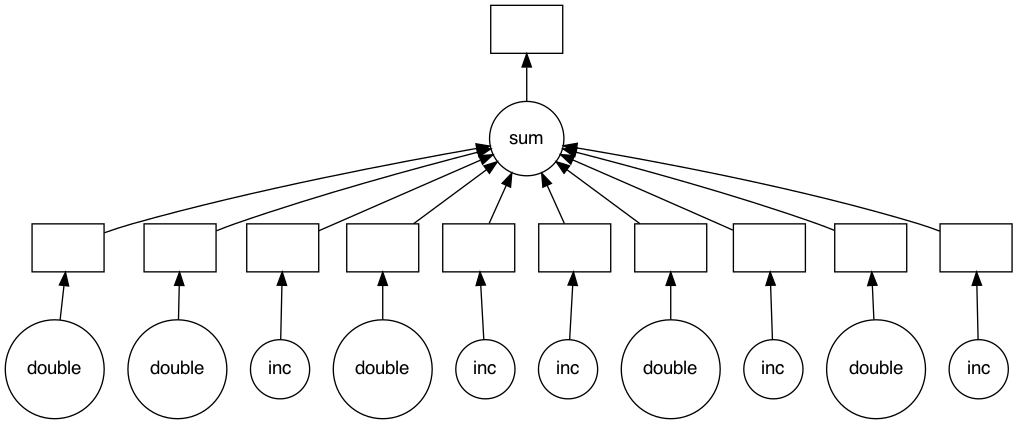

In [64]:
total.visualize()

## Challenge

**Add another layer of control flow** to square numbers divisible by 3. 

In [ ]:
# add control flow to square numbers divisible by 5

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [25]:
client.close()

### Some questions to consider:

-  What are other examples of control flow where we can't use `dask.delayed`?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

**Notes**

Delayed objects support various operations:
```python
    x2 = x + 1
```

If `x` was a delayed result (like `total`, above), then so is `x2`. Supported operations include arithmetic operators, item or slice selection, attribute access and method calls - essentially anything that could be phrased as a `lambda` expression.

Operations which are *not* supported include mutation, setter methods, iteration (for) and bool (predicate).

## Conclusion

Hopefully this basic intro has given you the tools to work `Dask` delayed for parallel computation of arbitrary code.

**Jump over to [Notebook 3](./dask_dataframe_03.ipynb) now.** 